# Times

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
import os
from collections import defaultdict

import pickle

In [2]:
training_times = []
file = 'training_times.dat'
with open(file) as f:
    for line in f:
        tokens = line.split()
        training_times.append((tokens[0], int(tokens[1][3:]),int(tokens[2][2:]),int(tokens[3][2:-1]),float(tokens[5].replace(",","."))))
training_times.sort(key = lambda x: x[2])
print(training_times)

[('planetary_tr', 20, 270550, 6195, 12.381876230239868), ('planetary_2', 20, 270550, 21973, 12.798418521881104), ('planetary_full', 20, 270550, 24006, 12.483670711517334), ('alma_band_6_tr', 133, 677658, 65, 28.44726252555847), ('alma_band_6_2', 133, 677658, 6400, 31.341835021972656), ('alma_band_6_full', 133, 677658, 79617, 31.904292106628418), ('planetary_expanded_00100', 20, 766120, 167626, 34.6296107769), ('planetary_expanded_01000', 20, 769986, 167776, 34.9770591259), ('planetary_expanded_00050', 20, 769998, 167604, 34.7039940357), ('extragalactic_tr', 36, 779933, 9032, 33.37032198905945), ('extragalactic_2', 36, 779933, 51664, 34.436983585357666), ('extragalactic_full', 36, 779933, 65293, 34.571043968200684), ('comets_tr', 30, 1147965, 9349, 48.88838052749634), ('comets_2', 30, 1147965, 70080, 50.456461668014526), ('comets_full', 30, 1147965, 98875, 49.80871224403381), ('diffuse_clouds_tr', 24, 1475847, 7684, 62.33177590370178), ('diffuse_clouds_2', 24, 1475847, 73104, 63.7936408

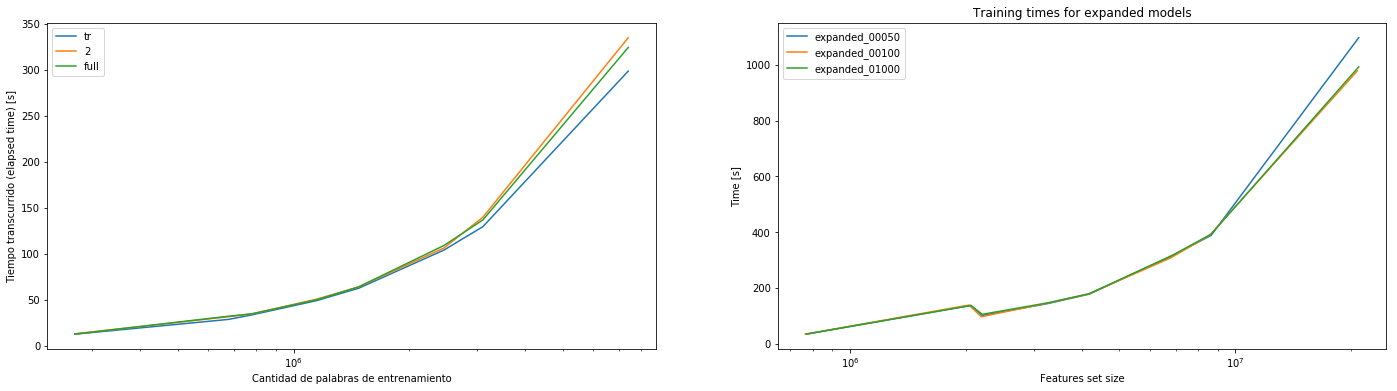

In [3]:
models = ['tr','2','full','expanded_00050','expanded_00100','expanded_01000']
training_times.sort(key = lambda x: x[2])
#training_times.sort(key = lambda x: (x[2],x[1]))
fig = plt.figure(figsize=(24,6))
for i,model in enumerate(models):
    if i == 0:
        fits_plots = []
        plt.subplot(1,2,1)
    elif i == 3:
        fits_plots = []
        plt.subplot(1,2,2)
    
    training_times_plot = [x for x in training_times if x[0].endswith(model)]
    mPlot, = plt.plot([x[2] for x in training_times_plot],[x[4] for x in training_times_plot], label = model)
    fits_plots.append(mPlot)
    
    if i == 2:
        #plt.title("Tiempos de entrenamiento for standard models")
        #plt.xlabel("Number of training words")
        plt.xlabel("Cantidad de palabras de entrenamiento")
        #plt.ylabel("Elapsed time [s]")
        plt.ylabel("Tiempo transcurrido (elapsed time) [s]")
        plt.xscale("log")
        plt.legend(handles=fits_plots)
    elif i == 5:
        plt.title("Training times for expanded models")
        plt.xlabel("Features set size")
        plt.ylabel("Time [s]")
        plt.xscale("log")
        plt.legend(handles=fits_plots)
    
#plt.xticks(range(len(training_times_plot)),["_".join(x[0].split("_")[:-1]) for x in training_times_plot], rotation = "vertical")

#plt.xscale("log")
plt.show()

In [4]:
time_results = []

#Obtain times from inference output
filename = './results_casted_all_10it/nohup.out'
fitsname = ''
modelname = ''
with open(filename) as f:
    for line in f:
        fitsname = line.split(":")[1].strip()[11:] if "Parsing Fits:" in line else fitsname
        modelname = line.split(":")[1].strip()[6:-6] if "Used model:" in line else modelname 
        
        if "Parsing time" in line:
            exectime = dict()
            exectime['parser'] = float(line.split(":")[1].split()[0])
        elif "L-LDA inference time" in line:
            exectime['llda'] = float(line.split(":")[1].split()[0])
        elif "Total execution time" in line:
            exectime['total'] = float(line.split(":")[1].split()[0])
            time_results.append((fitsname, modelname,exectime))
        
#Obtain models metadata
model_names = list(set([model for fits,model,exectime in time_results if model != '']))
#models_metadata = defaultdict(lambda: defaultdict(int))
models_metadata = dict()
for model in model_names:
	models_metadata[model] = dict()

pickle_models_filename = 'models_metadata.dmp'

if not os.path.isfile(pickle_models_filename):
	print("Reading models metadata...")
	#Obtain number of features (vocabulary) per model
	for i,model in enumerate(model_names):
	    with open('./llda_train_input/'+model+'_features.dat') as f:
	        line = f.readline()
	        models_metadata[model]['vocabulary_len'] = len(line.split())
	#Obtain number of tokens per model
	for model in model_names:
	    #model_data = "_".join(model.split('_')[:-1]) if "expanded" not in model else "_".join(model.split('_')[:-3]) 
	    with open('./llda_train_input/'+model+'.dat') as f:
	        tokens_count = 0
	        for line in f:
	                tokens_count += len(line.split())
	        models_metadata[model]['tokens_len'] = tokens_count

	#Obtain number of topics per model
	for model in model_names:
	    if 'expanded' in model:
	        tokens = model.split('_expanded')
	        labelmap_path = './llda_train_input/'+tokens[0]+'_labelmap.sub'
	    else:
	        labelmap_path = './llda_train_input/'+model+'_labelmap.sub'
	    
	    with open(labelmap_path) as f:
	        topics_count = 0
	        for line in f:
	        	topics_count += 1
	        models_metadata[model]['topics_count'] = topics_count

	pickleout = open(pickle_models_filename,'wb')
	pickle.dump(models_metadata,pickleout)
	pickleout.close()
else:
	print("Recovering models metadata from pickle dump...")
	picklein = open(pickle_models_filename,'rb')
	models_metadata = pickle.load(picklein)
	picklein.close()
    
#Obtain FITS metadata
fits_names = list(set([fits for fits,model,exectime in time_results]))
fits_metadata = defaultdict(int)

fits_metadata['HD163296_CO_2_1.image.fits'] = 432*432*250
fits_metadata['uid___A002_Xa916fc_X668__IRS43_HCO32.final.image.pbcor.fits'] = 512*512*400
fits_metadata['uid___A002_Xa916fc_X668__IRS43_HCO32.final.image.pbcor.v2.fits'] = 512*512*400
fits_metadata['Orion.HNC.cbc.contsub.image.fits'] = 450*450*121
fits_metadata['Orion.HNC.cbc.contsub.image.v2.fits'] = 450*450*121
fits_metadata['DMTau.CS_5-4.image.fits'] = 420*420*330
fits_metadata['Orion.methanol.cbc.contsub.image.fits'] = 100*100*41
fits_metadata['Orion.methanol.cbc.contsub.image.v2.fits'] = 100*100*41
fits_metadata['TWHydra_CO3_2line.image.fits'] = 100*100*118
fits_metadata['TWHydra_HCOplusline.image.fits'] = 100*100*118
fits_metadata['TWHydra_HCOplusline.image.v2.fits'] = 100*100*118

#Getting Times
llda_times_dict = defaultdict(lambda: defaultdict(lambda: list()))
parser_times_dict = defaultdict(lambda: defaultdict(lambda: list()))
total_time_dict = defaultdict(lambda: defaultdict(lambda: list()))

for fitsname, modelname, exectime in time_results:
    llda_times_dict[modelname][fitsname].append(exectime['llda'])
    parser_times_dict[modelname][fitsname].append(exectime['parser'])
    total_time_dict[modelname][fitsname].append(exectime['total'])

Recovering models metadata from pickle dump...


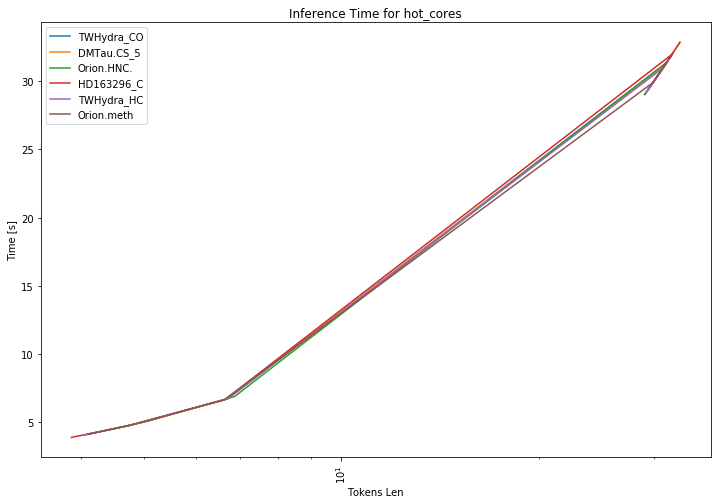

In [6]:
pModel = 'hot_cores'
fig = plt.figure(figsize=(12,8))

llda_average_times = [(model,fits,sum(times)/float(len(times))) for model, fits_dict in llda_times_dict.items() for fits, times in fits_dict.items()]
llda_average_times_models = []

# models = ["_".join(model.split("_")[:-1]) if "expanded" not in model else "_".join(model.split("_")[:-4]) for model in model_names]
# models = list(set(models))
# for j,pModel in enumerate(models):
# 	plt.subplot(4,2,j+1)
fits = [fits for model,fits,time in llda_average_times if pModel in model]
fits = list(set(fits))
fits_plots = []
for i, fitsname in enumerate(fits):
    average_times = sorted([(model,time) for model,fits,time in llda_average_times if fits == fitsname and pModel in model], key = lambda x: (models_metadata[x[0]]['vocabulary_len'],models_metadata[x[0]]['topics_count']))
    mPlot, = plt.plot([time for model, time in average_times],[time for model, time in average_times], label=fitsname[:10])
    fits_plots.append(mPlot)

plt.title("Inference Time for "+pModel)
plt.xticks(range(len(average_times)),[model.split("_")[-1] if "expanded" not in model else "e"+model.split("_")[-2]  for model,time in average_times], rotation = 'vertical')
plt.ylabel("Time [s]")
plt.xlabel("Tokens Len")
plt.xscale('log')
plt.legend(handles=fits_plots)

# parser_average_times = [(model,fits,sum(times)/float(len(times))) for model, fits_dict in parser_times_dict.items() for fits, times in fits_dict.items()]
# parser_average_times_model = [time for model,fits,time in llda_average_times if model.endswith(model)]
# plt.tight_layout()
plt.show()